# How to Run MMLU with Generative Models (Hugging Face Transformers)
Based on: https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/run_mmlu_open_source.py

In [1]:
import json
import os
import time
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 5.19 MiB/s, done.


In [3]:
!git clone https://github.com/FranxYao/chain-of-thought-hub

Cloning into 'chain-of-thought-hub'...
remote: Enumerating objects: 3043, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 3043 (delta 191), reused 247 (delta 179), pack-reused 2704
Receiving objects: 100% (3043/3043), 8.30 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (964/964), done.


In [4]:
HF_CACHE_LOCATION = "/data/shk148/models/opt/cache"

TASKS = [
        'abstract_algebra',
        'anatomy',
        'astronomy',
        'business_ethics',
        'clinical_knowledge',
        'college_biology',
        'college_chemistry',
        'college_computer_science',
        'college_mathematics',
        'college_medicine',
        'college_physics',
        'computer_security',
        'conceptual_physics',
        'econometrics',
        'electrical_engineering',
        'elementary_mathematics',
        'formal_logic',
        'global_facts',
        'high_school_biology',
        'high_school_chemistry',
        'high_school_computer_science',
        'high_school_european_history',
        'high_school_geography',
        'high_school_government_and_politics',
        'high_school_macroeconomics',
        'high_school_mathematics',
        'high_school_microeconomics',
        'high_school_physics',
        'high_school_psychology',
        'high_school_statistics',
        'high_school_us_history',
        'high_school_world_history',
        'human_aging',
        'human_sexuality',
        'international_law',
        'jurisprudence',
        'logical_fallacies',
        'machine_learning',
        'management',
        'marketing',
        'medical_genetics',
        'miscellaneous',
        'moral_disputes',
        'moral_scenarios',
        'nutrition',
        'philosophy',
        'prehistory',
        'professional_accounting',
        'professional_law',
        'professional_medicine',
        'professional_psychology',
        'public_relations',
        'security_studies', 
        'sociology',
        'us_foreign_policy',
        'virology',
        'world_religions'
        ]

choices = ["A", "B", "C", "D"]
DATA_DIR = "/kaggle/working/chain-of-thought-hub/MMLU/data/"

In [5]:
os.chdir("/kaggle/working/watermark/demo")

In [6]:
import os
import argparse
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from mersenne import mersenne_rng
import pandas as pd
from tqdm import tqdm
import numpy as np  # Import numpy for array slicing

def generate_shift(model, prompt, vocab_size, n, m, key):
    rng = mersenne_rng(key)
    xi = torch.tensor([rng.rand() for _ in range(n*vocab_size)]).view(n, vocab_size)
    shift = torch.randint(n, (1,))

    inputs = prompt.to(model.device)
    attn = torch.ones_like(inputs)
    past = None
    for i in range(m):
        with torch.no_grad():
            if past:
                output = model(inputs[:, -1:], past_key_values=past, attention_mask=attn)
            else:
                output = model(inputs)

        probs = torch.nn.functional.softmax(output.logits[:, -1, :vocab_size], dim=-1).cpu()
        token = exp_sampling(probs, xi[(shift+i)%n, :]).to(model.device)
        inputs = torch.cat([inputs, token], dim=-1)

        past = output.past_key_values
        attn = torch.cat([attn, attn.new_ones((attn.shape[0], 1))], dim=-1)

    return inputs.detach().cpu()

def exp_sampling(probs, u):
    return torch.argmax(u ** (1/probs), axis=1).unsqueeze(-1)


In [7]:
# Helper Functions: Largely unchanged from https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/run_mmlu_open_source.py

def compute_metric(output_filename):
    with open(output_filename, 'r') as f:
        run_results = json.load(f)
    total_acc = 0
    total_num = 0
    for task in run_results:
        acc = 0
        pred_answers = run_results[task]['pred_answers']
        gold_answers = run_results[task]['gold_answers']
        for pred, gold in zip(pred_answers, gold_answers):
            if pred == gold: acc += 1
        print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
        total_acc += acc
        total_num += len(gold_answers)
    print("ACC-all: %.4f" % (total_acc/total_num))


def format_subject(subject):
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

def format_example(df, idx, include_answer=True):
    prompt = df.iloc[idx, 0]
    k = df.shape[1] - 2
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df.iloc[idx, j+1])
    prompt += "\nAnswer:"
    if include_answer:
        prompt += " {}\n\n".format(df.iloc[idx, k + 1])
    return prompt

def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(format_subject(subject))
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt

def prepare_input(tokenizer, prompts):
    input_tokens = tokenizer.batch_encode_plus(prompts, return_tensors="pt", padding=True)
    input_tokens = {k:input_tokens[k] for k in input_tokens if k in ["input_ids", "attention_mask"]}
    for t in input_tokens:
        if torch.is_tensor(input_tokens[t]):
            input_tokens[t] = input_tokens[t].to('cuda')

    return input_tokens

def batch_split(prompts, batch_num):
    batch_prompts = []
    mini_batch = []
    for prompt in prompts:
        mini_batch.append(prompt)
        if len(mini_batch) == batch_num:
            batch_prompts.append(mini_batch)
            mini_batch = []
    if len(mini_batch) != 0:
        batch_prompts.append(mini_batch)
    return batch_prompts

def batch_infer(model, tokenizer, prompts):
    batch_size = 8
    answers = []
    for batch_input in tqdm(batch_split(prompts, batch_size)):
        encode_inputs = prepare_input(tokenizer, batch_input)
        outputs = model.generate(**encode_inputs, max_new_tokens=1, pad_token_id=tokenizer.pad_token_id)
        answers.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    answers = [answer[-1] for answer in answers]
    return answers

def infer_with_watermark(model, tokenizer, prompts):
    batch_size = 1
    answers = []
    for prompt in tqdm(prompts, total = len(prompts)):
        tokens = tokenizer.encode(prompt, return_tensors='pt', truncation=True, max_length=2048)
        with torch.no_grad():
            watermarked_tokens = generate_shift(model,tokens,len(tokenizer),256,1,42)[0]
            watermarked_text = tokenizer.decode(watermarked_tokens, skip_special_tokens=True)
            answers.append(watermarked_text)
    answers = [answer[-1] for answer in answers]
    return answers


In [8]:
def load(checkpoint, model_type):
    n_gpus = torch.cuda.device_count()
    
    model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=HF_CACHE_LOCATION).cuda()
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=HF_CACHE_LOCATION, padding_side='left')      
    model.eval()
    return model, tokenizer

In [9]:
TASKS = [
        'abstract_algebra',
        'anatomy',
        'astronomy',
        'business_ethics',
        'clinical_knowledge'
        ]

In [10]:
def main(ckpt_dir: str, param_size: str, model_type: str):
    
    run_results = {}
    output_filename = 'run_results_%s_%sb.json' % (model_type, param_size)
    
    model, tokenizer = load(ckpt_dir, model_type)
    start_time = time.time()
    all_records = []
    for task in TASKS:
        print('Testing %s ...' % task)
        records = []
        dev_df = pd.read_csv(os.path.join(DATA_DIR, "dev", task + "_dev.csv"), header=None)[:5]
        test_df = pd.read_csv(os.path.join(DATA_DIR, "test", task + "_test.csv"), header=None)
        for i in range(test_df.shape[0]):
            # get prompt and make sure it fits
            k = 5
            prompt_end = format_example(test_df, i, include_answer=False)
            train_prompt = gen_prompt(dev_df, task, k)
            prompt = train_prompt + prompt_end
            while len(tokenizer.tokenize(prompt)) + 1> 2048: # bos token
                prompt_split = prompt.split("\n\n")
                prompt_split.pop(1)
                prompt = '\n\n'.join(prompt_split)
#             print(prompt)
            label = test_df.iloc[i, test_df.shape[1]-1]
            records.append({'prompt':prompt, 'answer':label})

        pred_answers = infer_with_watermark(model, tokenizer, [record['prompt'] for record in records])
        gold_answers = [record['answer'] for record in records]
        all_records.append(records)
        run_results[task] = {'pred_answers':pred_answers, 'gold_answers':gold_answers}
    with open(output_filename, 'w') as f:
        json.dump(run_results, f, ensure_ascii=False, indent=2)
    
    compute_metric(output_filename)
    end_time = time.time()
    print("total run time %.2f" % (end_time - start_time))
    del model
    del tokenizer
    return run_results

In [11]:

draft_models = [
	"facebook/opt-350m"
]
rslt = dict()

for draft_model in draft_models:
    rslt[draft_model] =  main(draft_model, draft_model.replace("facebook/opt-", ""), "OPT")
    gc.collect()
    torch.cuda.empty_cache()
# rslt[draft_model]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Testing abstract_algebra ...


100%|██████████| 100/100 [1:14:32<00:00, 44.73s/it]


Testing anatomy ...


100%|██████████| 135/135 [1:42:01<00:00, 45.34s/it]


Testing astronomy ...


100%|██████████| 152/152 [1:57:21<00:00, 46.32s/it]


Testing business_ethics ...


100%|██████████| 100/100 [1:16:51<00:00, 46.12s/it]


Testing clinical_knowledge ...


100%|██████████| 265/265 [3:24:06<00:00, 46.21s/it]


ACC-abstract_algebra: 0.2500
ACC-anatomy: 0.2296
ACC-astronomy: 0.1711
ACC-business_ethics: 0.2400
ACC-clinical_knowledge: 0.2679
ACC-all: 0.2354
total run time 34495.60


In [12]:
import pandas as pd

def transform_all_tasks(run_results):
    """
    Transforms all tasks in run_results dictionary to a single DataFrame.

    Args:
      run_results: Dictionary containing results for multiple tasks.

    Returns:
      pandas.DataFrame: DataFrame with columns 'task_name' (optional), 'prompt' (optional), 'prediction' and 'gold_label'.
    """
    data = []
    for task_name, task_results in run_results.items():
        # Check if 'prompt' key exists in task_results
        if 'prompt' in task_results:
            prompts = task_results['prompt']
            for i in range(len(prompts)):
                data.append({
                'task_name': task_name,
                'prompt': prompts[i],
                'prediction': task_results['pred_answers'][i],
                'gold_label': task_results['gold_answers'][i]
                })
        else:
            for i in range(len(task_results['pred_answers'])):
                data.append({
                'task_name': task_name,
                'prediction': task_results['pred_answers'][i],
                'gold_label': task_results['gold_answers'][i]
                })
    return pd.DataFrame(data)

# Transform all tasks in run_results to DataFrame
df = transform_all_tasks(rslt[draft_model])
# print(df)


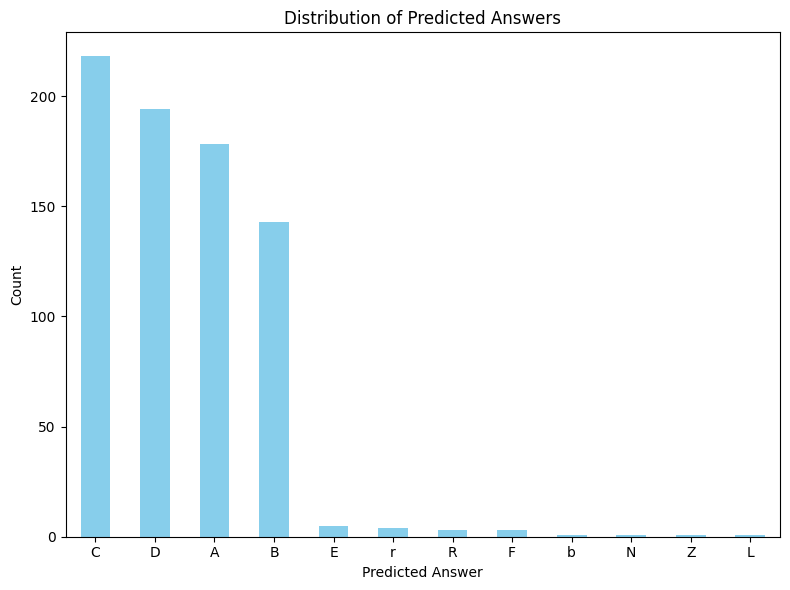

In [13]:
import matplotlib.pyplot as plt

def analyze_predictions(df):
    """
    Analyzes predicted answers from a CSV file and creates a bar chart.

    Args:
      filename: Path to the CSV file containing "predicted_answer" column.
    """

    # Count occurrences of each predicted answer
    answer_counts = df['prediction'].value_counts()

    # Create bar chart
    plt.figure(figsize=(8, 6))
    answer_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Predicted Answer')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Answers')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

analyze_predictions(df)
